# Installs

# Imports

In [ ]:
import argparse
import shap
import csv
import os
import sys
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import statistics
import scipy.stats
import statsmodels.api as sm

from scipy.stats import zscore
from operator import itemgetter
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler

Mounted at /content/drive


# Preprocessing

In [ ]:
# Load data
def load_csv_data(file_path):
    data = []
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        next(csv_reader)  # Skip the first row
        for row in csv_reader:
            data.append(row)
    return np.array(data, dtype=float)

In [ ]:
def execute_output(models_set, target_data, demo_target_data, calculation_type):
    outputs = []

    for model in models_set:
        output = model(torch.cat([target_data, demo_target_data], dim=1))
        outputs.append(output)

    stacked_outputs = torch.stack(outputs)

    if calculation_type == 'mean':
        output_result = torch.mean(stacked_outputs, dim=0)
    elif calculation_type == 'median':
        output_result = torch.median(stacked_outputs, dim=0).values
    else:
        raise ValueError("Invalid calculation type. Please choose between 'mean' or 'median'.")

    return output_result

In [ ]:
def execute_latent(models_set, target_data, demo_target_data, calculation_type):
    outputs = []

    for model in models_set:
        output = model.encoder(torch.cat([target_data, demo_target_data], dim=1))
        outputs.append(output)

    stacked_outputs = torch.stack(outputs)

    if calculation_type == 'mean':
        output_result = torch.mean(stacked_outputs, dim=0)
    elif calculation_type == 'median':
        output_result = torch.median(stacked_outputs, dim=0).values
    else:
        raise ValueError("Invalid calculation type. Please choose between 'mean' or 'median'.")

    return output_result

In [ ]:
def ensemble_shap(models_set, feature, control, patient, calculation_type):
  expected_values = []
  shap_values_list = []
  for model in models_set:
    model_0 = get_zero_feature_model(model, feature)  # excludes the influence of feature i on itself

  # Explainer
    explainer = shap.DeepExplainer(model_0, control)
    expected_values.append(explainer.expected_value)

  # Shap values
    shap_values = explainer.shap_values(patient)
    shap_values_list.append(shap_values)

#  Calculate the ensemble's SHAP values by taking the median/mean across the models
  if calculation_type == 'mean':
        ensemble_shap_values = np.mean(shap_values_list, axis=0)
        expected_values = np.mean(expected_values, axis=0)
  elif calculation_type == 'median':
        ensemble_shap_values = np.median(shap_values_list, axis=0)
        expected_values = np.median(expected_values, axis=0)
  else:
    raise ValueError("Invalid calculation type. Please choose between 'mean' or 'median'.")

  return expected_values, ensemble_shap_values

# Autoencoder

In [ ]:
class AutoEncoderNN(nn.Module):
    def __init__(self, num_features, num_demo, dropout_prob=0.0):
        super(AutoEncoderNN, self).__init__()
        self.size_input = num_features
        self.size_demo = num_demo
        self.size_hidden = (self.size_input - 3) + (self.size_demo - 2)
        self.size_hidden2 = self.size_hidden - 2 - 1 -2
        self.size_latent = self.size_hidden2 - 3 -2

        # Imaging branch
        self.encoder = nn.Sequential(
           nn.Linear(self.size_input + self.size_demo, self.size_hidden),
           nn.ReLU(),
           nn.Dropout(dropout_prob),
           nn.Linear(self.size_hidden, self.size_hidden2),
           nn.ReLU(),
           nn.Dropout(dropout_prob),
           nn.Linear(self.size_hidden2, self.size_latent),
           nn.ReLU(),
           nn.Dropout(dropout_prob)
        )

        # Decoding
        self.decoder = nn.Sequential(
           nn.Linear(self.size_latent, self.size_input - 5),
           nn.ReLU(),
           nn.Dropout(dropout_prob),
           nn.Linear(self.size_input - 5, self.size_input - 3),
           nn.ReLU(),
           nn.Dropout(dropout_prob),
           nn.Linear(self.size_input - 3, self.size_input)
        )

    def forward(self, input):
         x = self.encoder(input)
         # Decode
         return self.decoder(x)

## Normalization

In [ ]:
def normalize_perfusion(data):
    # Divide the tensor by the maximum value (100) for perfusion
    data /= 100

    return data

In [ ]:
def normalize_diffusion(data):
    # Divide the tensor by the maximum value (3000) for diffusion
    data /= 3000

    return data

In [ ]:
def normalize_covariate(data):
    # Subtract the minimum value of each column (dimension 0) from the tensor
    data -= data.min(0, keepdim=True)[0]

    # Divide the tensor by the maximum value of each column (dimension 0)
    data /= data.max(0, keepdim=True)[0]

    return data

## Train

In [ ]:
def train_loop(epoch_num, fold_num, img_dataloader, demo_dataloader, model, mse_loss_fn, optimiser, x_loss):
    tot_loss = 0.0
    samples = 0

    model.train()

    for batch, (X, demo) in enumerate(zip(img_dataloader, demo_dataloader)):
        # Compute prediction and loss
        X_estim = model(torch.cat([X, demo], dim=1))
        loss = mse_loss_fn(X, X_estim)
        tot_loss += loss.item() * X.size(0)
        samples += X.size(0)

        # Backpropagation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()


    avg_loss = tot_loss / samples

    x_loss.append(avg_loss)

    return x_loss

## Validation

In [ ]:
def validation_loop(img_dataloader, demo_dataloader, model, mse_loss_fn, file_handle, x_loss):
    tot_loss = 0.0
    samples = 0

    model.eval()

    with torch.no_grad():
      for batch, (X, demo) in enumerate(zip(img_dataloader, demo_dataloader)):
        # Compute prediction and loss
        X_estim = model(torch.cat([X, demo], dim=1))
        loss = mse_loss_fn(X, X_estim)
        tot_loss += loss.item() * X.size(0)
        samples += X.size(0)

      avg_loss = tot_loss / samples

      x_loss.append(avg_loss)

    if file_handle is not None:
        print(f"{avg_loss:>8f}", file=file_handle)

    return x_loss

## Test

In [ ]:
def final_test(img_dataloader, demo_dataloader, model, mse_loss_fn):
    print("\n")
    print("---------------------------------------------------------------------")
    print("Final test")
    print("---------------------------------------------------------------------")

    dataloader = zip(img_dataloader, demo_dataloader)

    with torch.no_grad():
        for batch, (X, demo) in enumerate(dataloader):
            X_estim = model(torch.cat([X, demo], dim=1))
            print(X_estim, X)
            test_loss = mse_loss_fn(X, X_estim)
            print(f"Test MSE of batch {batch}: {test_loss:>8f}")

# Construct model

In [ ]:
# Files
model_out_file = 'autoencoder.pth'
csv_file_train_perfusion = 'control_train_perfusion.csv'
csv_file_train_diffusion = 'control_train_diffusion.csv'
csv_file_covariate = 'control_train_covariates.csv'
csv_file_test_perfusion = 'control_test_perfusion.csv'
csv_file_test_diffusion = 'control_test_diffusion.csv'
csv_file_covariate_test = 'control_test_covariates.csv'
txt_file_loss = 'loss_autoencoder.txt'
csv_patient_perfusion = 'patient_perfusion.csv'
csv_patient_diffusion = 'patient_diffusion.csv'
csv_patient_demo = 'patient_covariates.csv'

# Parameters
torch.manual_seed(100)
num_epochs = 1000
num_folds = 5
batch_size = 16

# Normalize
trainval_data_perfusion = normalize_perfusion(torch.from_numpy(np.loadtxt(csv_file_train_perfusion, delimiter=',', skiprows=1)).float())
trainval_data_diffusion = normalize_diffusion(torch.from_numpy(np.loadtxt(csv_file_train_diffusion, delimiter=',', skiprows=1)).float())
test_data_perfusion = normalize_perfusion(torch.from_numpy(np.loadtxt(csv_file_test_perfusion, delimiter=',', skiprows=1)).float())
test_data_diffusion = normalize_diffusion(torch.from_numpy(np.loadtxt(csv_file_test_diffusion, delimiter=',', skiprows=1)).float())
demo_train_data = normalize_covariate(torch.from_numpy(np.loadtxt(csv_file_covariate, delimiter=',', skiprows=1)).float())
demo_test_data = normalize_covariate(torch.from_numpy(np.loadtxt(csv_file_covariate_test, delimiter=',', skiprows=1)).float())
patient_demo = normalize_covariate(torch.from_numpy(pd.read_csv(csv_patient_demo, delimiter=',').values).float())
patient_perfusion = normalize_perfusion(torch.from_numpy(np.loadtxt(csv_patient_perfusion, delimiter=',', skiprows=1)).float())
patient_diffusion = normalize_diffusion(torch.from_numpy(np.loadtxt(csv_patient_diffusion, delimiter=',', skiprows=1)).float())

# Concatenate
trainval_data = torch.cat((trainval_data_perfusion, trainval_data_diffusion), dim=1)
test_data = torch.cat((test_data_perfusion, test_data_diffusion), dim=1)
patient_data = torch.cat((patient_perfusion, patient_diffusion), dim=1)
trainval = torch.cat((trainval_data, demo_train_data), dim=1)
test = torch.cat((test_data, demo_test_data), dim=1)
control = torch.cat((trainval, test), dim=0)
patient = torch.cat((patient_data, patient_demo), dim=1)
patient_numpy = patient.detach().numpy()

# Dataloaders
test_dataloader = DataLoader(test_data)
demo_test_dataloader = DataLoader(demo_test_data)
patient_dataloader = DataLoader(patient_data)
demo_patient_dataloader = DataLoader(patient_demo)

# Number of features
num_features_train = trainval_data.size(dim=1)
num_features_demo = demo_train_data.size(dim=1)
num_features_test = test_data.size(dim=1)

#MSE
mse_loss_fn = nn.MSELoss()

lr:  0.01


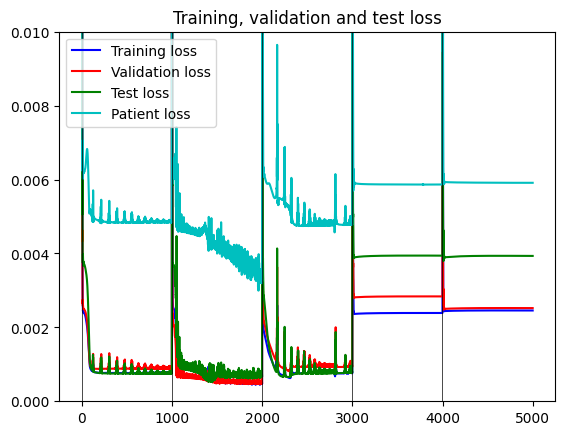

1000th epoch train loss average:  [0.0007763519650325179, 0.0004733252746518701, 0.0007584434584714473, 0.002389049553312361, 0.0024563098093494775]
1000th epoch validation loss average:  [0.0009017607429996133, 0.00047980109229683876, 0.0009346918785013258, 0.0028371620457619427, 0.0025214152527041735]
1000th epoch test loss average:  [0.0007716744483332149, 0.000664701106143184, 0.0007855089759686961, 0.003940046433126554, 0.003932873115991243]
lr:  0.005


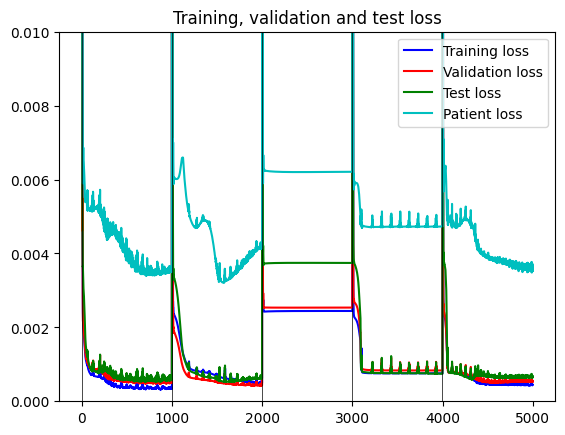

1000th epoch train loss average:  [0.0003407990676350892, 0.0004907812748569995, 0.00244296183809638, 0.0007556695956736803, 0.00044869825942441823]
1000th epoch validation loss average:  [0.0004961810016538947, 0.00043138348264619707, 0.0025351619580760596, 0.000833608175162226, 0.0005344752338714897]
1000th epoch test loss average:  [0.0005806966561067384, 0.0006237848036107607, 0.0037430899508763106, 0.0007444472081260756, 0.0006518352689454332]
lr:  0.001


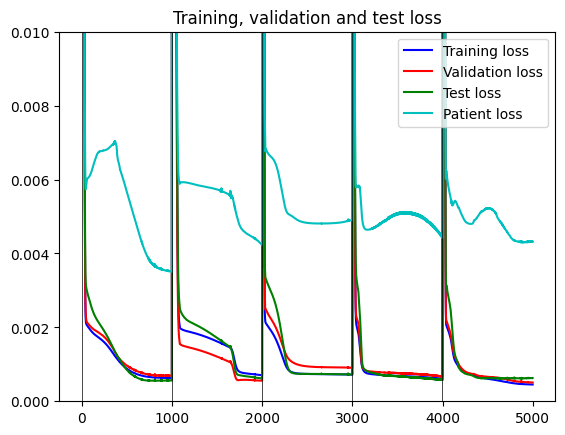

1000th epoch train loss average:  [0.0006257508997805416, 0.0007049532607197762, 0.0007191105862148107, 0.0006116734119132161, 0.00045373583561740815]
1000th epoch validation loss average:  [0.0006916946498677134, 0.000556102953851223, 0.0009062424069270492, 0.0006691048620268703, 0.0005077675974462182]
1000th epoch test loss average:  [0.0005631677253404632, 0.0006200013420311734, 0.0007252370662172325, 0.0005764446657849475, 0.0006297864965745248]
lr:  0.0005


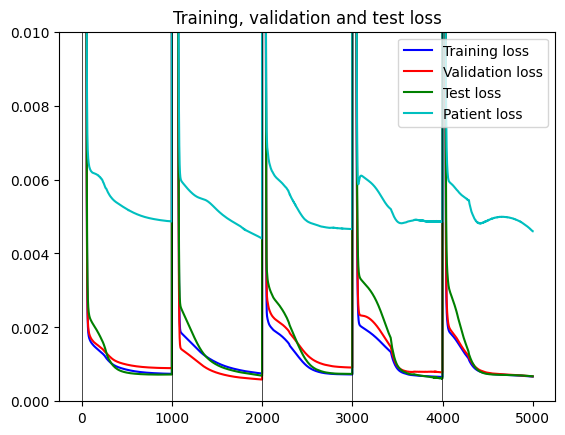

1000th epoch train loss average:  [0.0007429407211020589, 0.0007513155578635633, 0.0007251021568663418, 0.0006585960858501494, 0.000668080011382699]
1000th epoch validation loss average:  [0.0008957821992225945, 0.0005885819671675562, 0.0009129253099672497, 0.0007801002240739763, 0.0006742129742633551]
1000th epoch test loss average:  [0.0007243347805342637, 0.0006917203892953694, 0.0007403295283438637, 0.0006196085916599259, 0.0006768333303625695]
lr:  0.0001


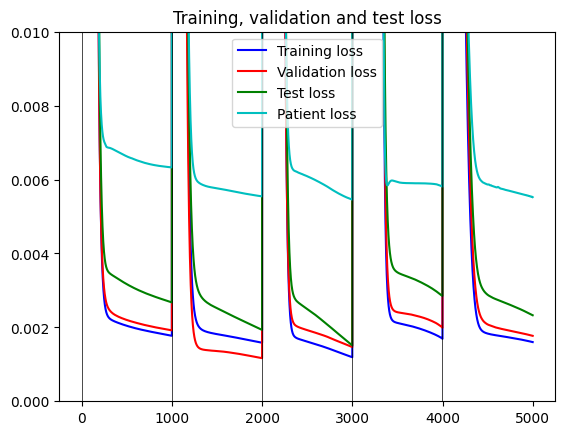

1000th epoch train loss average:  [0.0017719479743391275, 0.0015842010267078876, 0.0011917167576029897, 0.001689998246729374, 0.0016013520304113626]
1000th epoch validation loss average:  [0.0019185754703357817, 0.0011664719320833683, 0.0014660381362773477, 0.0019877483369782566, 0.0017708045663312078]
1000th epoch test loss average:  [0.002674908567860257, 0.0019313151569804177, 0.0015105867554666475, 0.002852403820725158, 0.00232750570285134]


In [ ]:
# Training

if os.path.splitext(model_out_file)[1].strip().lower() != '.pth':
    model_out_file = model_out_file + '.pth'

# Best models
best_model = AutoEncoderNN(num_features_train, num_features_demo)
best5models = []
best_median = float("inf")
best_loss = []

for i in [0.01, 0.005, 0.001, 0.0005, 0.0001]:

    learning_rate = i

    # Initialize the k-fold cross-validation
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=7)

    # Weights for the final model, calculated by taking the median of the 5 sets of weights
    weights = []
    models = []
    t_loss = []
    v_loss = []
    ts_loss = []
    p_loss = []

    for fold, (train_indices, val_indices) in enumerate(kfold.split(trainval_data)):
      model = AutoEncoderNN(num_features_train, num_features_demo)

      mse_loss_fn = nn.MSELoss()
      optimiser = optim.Adam(model.parameters(), lr=learning_rate)

      # Split the dataset into training and validation sets for the current fold
      train = trainval_data[train_indices, :]
      val = trainval_data[val_indices, :]
      train_dataloader = DataLoader(train, batch_size=batch_size)
      val_dataloader = DataLoader(val, batch_size=batch_size)
      demo_train_dataloader = DataLoader(demo_train_data[train_indices, :], batch_size=batch_size)
      demo_val_dataloader = DataLoader(demo_train_data[val_indices, :], batch_size=batch_size)

      if txt_file_loss is not None:
          file_handle = open(txt_file_loss, 'w')
      else:
          file_handle = None

      for t in range(num_epochs):
          train_loss = train_loop(t+1, fold+1, train_dataloader, demo_train_dataloader, model, mse_loss_fn, optimiser, t_loss)
          val_loss = validation_loop(val_dataloader, demo_val_dataloader, model, mse_loss_fn, file_handle, v_loss)
          test_loss = validation_loop(test_dataloader, demo_test_dataloader, model, mse_loss_fn, file_handle, ts_loss)
          pat_loss = validation_loop(patient_dataloader, demo_patient_dataloader, model, mse_loss_fn, file_handle, p_loss)

      # Append the weights of the model to the list
      weights.append(model.state_dict())

      # Add models to the list
      models.append(model)

      if file_handle is not None:
          file_handle.close()

    # Median weights of the models
    median_weights = {}
    for name in weights[0].keys():
        weight_list = [w[name] for w in weights]
        weights_np = np.array([ww.numpy() for ww in weight_list])
        median = np.median(weights_np, axis=0)
        median_weights[name] = torch.from_numpy(median)

    if statistics.median(val_loss[slice(num_epochs-1, num_folds*num_epochs, num_epochs)]) < best_median:
        best_median = statistics.median(val_loss[slice(num_epochs-1, num_folds*num_epochs, num_epochs)])
        best5models = models
        best_model.load_state_dict(median_weights)
        best_loss = [t_loss, v_loss, ts_loss, p_loss]

    print('lr: ', i)

    # Plot
    plt.figure()
    plt.plot(train_loss, 'b', label='Training loss')
    plt.plot(val_loss, 'r', label='Validation loss')
    plt.plot(test_loss, 'g', label='Test loss')
    plt.plot(pat_loss, 'c', label='Patient loss')
    plt.title('Training, validation and test loss')

    for i in range(num_folds):
      x_value = i * num_epochs
      plt.axvline(x_value - 1, linewidth=0.5, color='k')

    plt.legend()
    plt.ylim([0, 0.01])
    plt.show()
    plt.close()

    print('1000th epoch train loss average: ', train_loss[slice(num_epochs-1, num_folds*num_epochs, num_epochs)])
    print('1000th epoch validation loss average: ', val_loss[slice(num_epochs-1, num_folds*num_epochs, num_epochs)])
    print('1000th epoch test loss average: ', test_loss[slice(num_epochs-1, num_folds*num_epochs, num_epochs)])

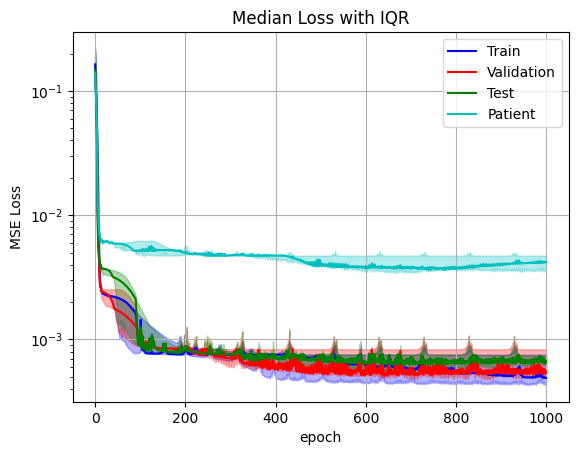



---------------------------------------------------------------------
Final test
---------------------------------------------------------------------
tensor([[0.1459, 0.1739, 0.0544, 0.1848, 0.2976, 0.1357, 0.1005, 0.1949, 0.1626,
         0.1994, 0.2611, 0.2147, 0.1877]]) tensor([[0.5862, 0.5550, 0.3861, 0.5632, 0.4963, 0.5956, 0.2981, 0.3122, 0.2583,
         0.2554, 0.2664, 0.2748, 0.2214]])
Test MSE of batch 0: 0.070240
tensor([[0.1458, 0.1739, 0.0544, 0.1847, 0.2976, 0.1356, 0.1006, 0.1948, 0.1626,
         0.1994, 0.2611, 0.2147, 0.1877]]) tensor([[0.5357, 0.5686, 0.3941, 0.5304, 0.5080, 0.6424, 0.2887, 0.3215, 0.2494,
         0.2506, 0.2606, 0.2583, 0.2233]])
Test MSE of batch 1: 0.069895
tensor([[0.1457, 0.1738, 0.0543, 0.1845, 0.2976, 0.1354, 0.1006, 0.1946, 0.1626,
         0.1993, 0.2610, 0.2146, 0.1877]]) tensor([[0.4237, 0.5059, 0.3119, 0.4117, 0.4101, 0.5566, 0.3612, 0.3846, 0.2885,
         0.2837, 0.3172, 0.3370, 0.2592]])
Test MSE of batch 2: 0.049684
tensor([[0.14

In [ ]:
# ...

reshap_loss = [np.array(l).reshape(-1, num_epochs) for l in best_loss]
medians = [np.median(l, axis=0) for l in reshap_loss]
q1s = [np.percentile(l, 25, axis=0) for l in reshap_loss]
q3s = [np.percentile(l, 75, axis=0) for l in reshap_loss]

# Joint plot
lab = ["Train", "Validation", "Test", "Patient"]
color = ['b', 'r', 'g', 'c']

for i in range(4):
    plt.plot(medians[i], label=lab[i], color=color[i])
    plt.fill_between(np.arange(num_epochs), q1s[i], q3s[i], alpha=0.3, color=color[i])

# Create a custom legend for the curves
handles = [plt.Line2D([0], [0], color=color[i], label=lab[i]) for i in range(4)]

plt.grid(True)
plt.title('Median Loss with IQR')
plt.yscale('log')
plt.ylabel('MSE Loss')
plt.xlabel('epoch')
plt.legend(handles=handles)
plt.show()

try:
    # torch.save(best_model, model_out_file)
    final_test(test_dataloader, demo_test_dataloader, best_model, mse_loss_fn)
    # print('Data', test_data)
    print('Median mod:', best_model(torch.cat([test_data, demo_test_data], dim=1)))
    # guardarlos tb

except Exception as e:
    err_message = str(e)
    sys.stderr.write(f"error: Could not save model. Message: {err_message}\n")

In [ ]:
# Loop over the models and save them
for i, model in enumerate(best5models):
     filename = f"/content/drive/My Drive/AT/encoder/vanilla_model{i}.pth"
     torch.save(model.state_dict(), filename)

best5models = []

for i in range(5):
    filename = f"/content/drive/My Drive/AT/encoder/vanilla_model{i}.pth"
    model = AutoEncoderNN(num_features_train, num_features_demo) #

    # Load the model state dictionary from the file
    model.load_state_dict(torch.load(filename))

    best5models.append(model)

# Evaluate patients

In [ ]:
# Construct model

# Target
target_data =  patient_data #
demo_target_data = patient_demo #


# Model outputs (mean or median of the 5 models' output)
output_mean = execute_output(best5models, target_data, demo_target_data, 'mean')
output_median = execute_output(best5models, target_data, demo_target_data, 'median')
output_median_ct = execute_output(best5models, control[:,0:13], control[:,13:], 'median')

# Count trainable parameters
#print(sum(p.numel() for p in model.parameters() if p.requires_grad))

# Calculate the MSE losses
loss_mean = mse_loss_fn(target_data, output_mean)
loss_median = mse_loss_fn(target_data, output_median)

# Results
results = {
    'Data': target_data.detach().numpy(),
    'Output means: ': output_mean.detach().numpy(),
    'Output medians: ': output_median.detach().numpy(),
    'Loss mean: ': loss_mean.item(),
    'Loss median: ': loss_median.item()
}

error = pd.DataFrame((target_data - output_median).detach().numpy())

In [ ]:
# Zero-feature model
def get_zero_feature_model(in_model, feature_num):
    out_model = copy.deepcopy(in_model)
    num_rows = out_model.state_dict()['encoder.0.weight'].size(dim=0)

    for i in range(num_rows):
        out_model.state_dict()['encoder.0.weight'][i, feature_num] = 0

    return out_model

In [ ]:
# Evaluate patients
def evaluate_patients(patient_dataloader, patient_demo_dataloader, control, model, file_handle):
    dataloader = zip(patient_dataloader, patient_demo_dataloader)

    for batch, (X, demo) in enumerate(dataloader):
        X_estim = execute_output(model, X, demo, 'median')
        # print(f"EST {X_estim}")
        # print(f"OBS {X}")

        sq_errors = torch.flatten(torch.pow( (X - X_estim), 2))
        # print(f"ERR {sq_errors}")

        mse_error = torch.mean(sq_errors)
        total_sq_error = torch.sum(sq_errors)
        features_sorted = torch.argsort(sq_errors, dim=0, descending=True)
        # print(features_sorted)

        num_features = X.size(dim=1)
        # print(num_features)

        print("---------------------------------------------------------------------")
        print(f"Batch {batch}")
        print("---------------------------------------------------------------------")
        print(f"MSE error: {mse_error:>8f}\n")

        if file_handle is not None:
            print(mse_error.detach().numpy(), file=file_handle)

        curr_sq_error = 0

        for num_top_features in range(num_features):
            curr_sq_error += sq_errors[features_sorted[num_top_features]]
            if curr_sq_error >= 0.8 * total_sq_error:
                break

        num_top_features += 1
        print(f"Num feat {num_features} - Num top feat {num_top_features}")

        for i in range(num_top_features):
            feat_idx = features_sorted[i]
            expected_value, shap_values = ensemble_shap(best5models, feat_idx, control, torch.cat((X, demo), dim=1), 'median')
            shap_values = np.transpose(shap_values, (2, 0, 1))
            shap_values = shap_values[feat_idx] #en 2024/march shap_values[feat_idx]

          #  model_zeroed = get_zero_feature_model(model[0], feat_idx)
          #  explainer = shap.DeepExplainer(model_zeroed, control)
          #  shap_values = explainer.shap_values(torch.cat((X, demo), dim=1))[0][feat_idx]
            print(f"SHAP values for feature {feat_idx} (original scale): {np.concatenate((shap_values[:6] * 100,  shap_values[6:] * 3000))}")

evaluate_patients(DataLoader(patient_data, batch_size=1), DataLoader(patient_demo, batch_size=1), control, best5models, None)

---------------------------------------------------------------------
Batch 0
---------------------------------------------------------------------
MSE error: 0.004899

Num feat 13 - Num top feat 2
SHAP values for feature 11 (original scale): [[ 0.          0.0289703  -0.02445965  0.          0.          0.
  -0.00186028 -0.019997    0.09338421 -0.01029333  0.03131191  0.
   0.37045763 -0.60228603  0.35174168  0.01203459  0.          0.
  -0.00688381 -0.04878652]]
SHAP values for feature 0 (original scale): [[ 0.00000000e+00 -8.70656129e-01  7.98425870e-02 -1.30853066e+00
  -6.76195743e-01 -3.12665710e-01 -2.76753008e-04  0.00000000e+00
   2.75812694e-02  4.28128114e-02 -7.13901172e-03  1.55766206e+00
  -1.42892112e-01  0.00000000e+00  7.36242393e-02 -1.72269088e-01
   0.00000000e+00 -7.18760421e-02 -7.94772466e-02 -7.62889744e-02]]
---------------------------------------------------------------------
Batch 1
---------------------------------------------------------------------
MSE err

# SHAP plots



In [ ]:
# Column names
diffusion_columns = ["Caudate",	"Hippocampus",	"Pallidum",	"Putamen",	"Thalamus",	"Cerebellar Grey Matter", "Cerebellar White Matter"]
perfusion_columns = ["Caudate",	"Hippocampus",	"Pallidum",	"Putamen",	"Thalamus",	"Cerebellar Grey Matter"]
column_names = [s + " Perfusion" for s in perfusion_columns] + [s + " Diffusion" for s in diffusion_columns]


(16, 20, 13) (13,)
Beeswarm Plot for feature 0
Beeswarm Plot for Caudate Perfusion


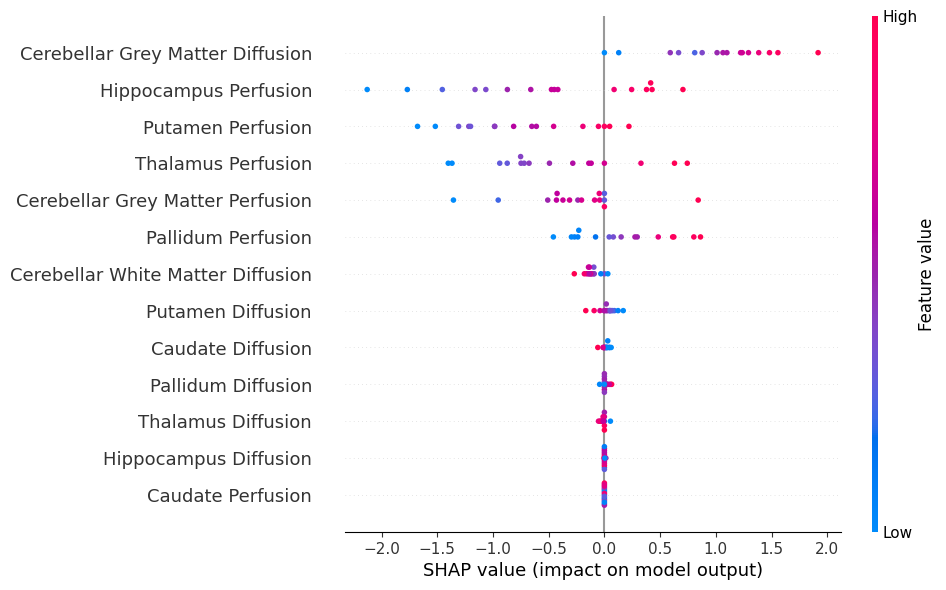

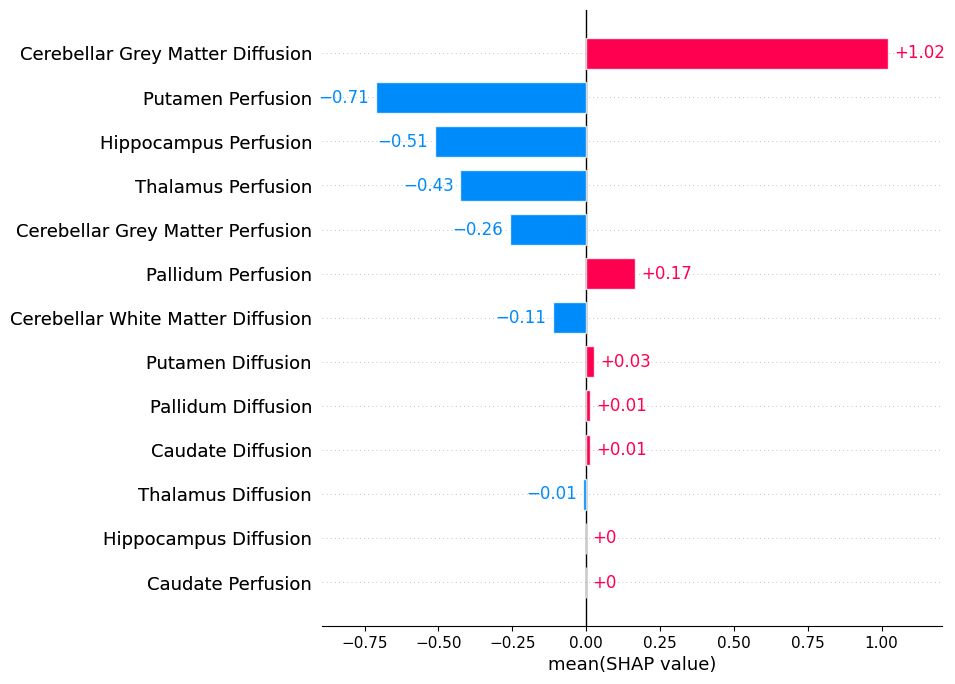



(16, 20, 13) (13,)
Beeswarm Plot for feature 1
Beeswarm Plot for Hippocampus Perfusion


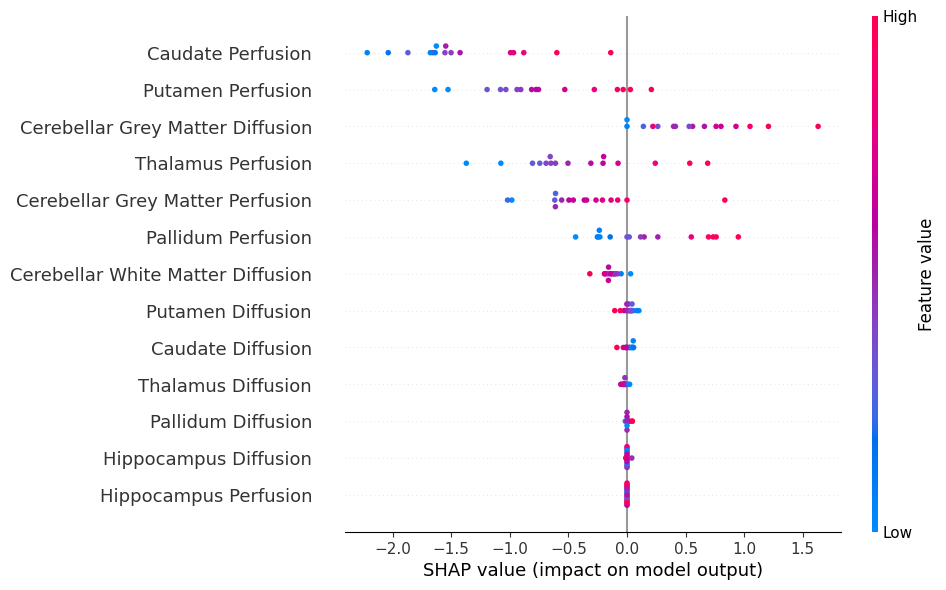

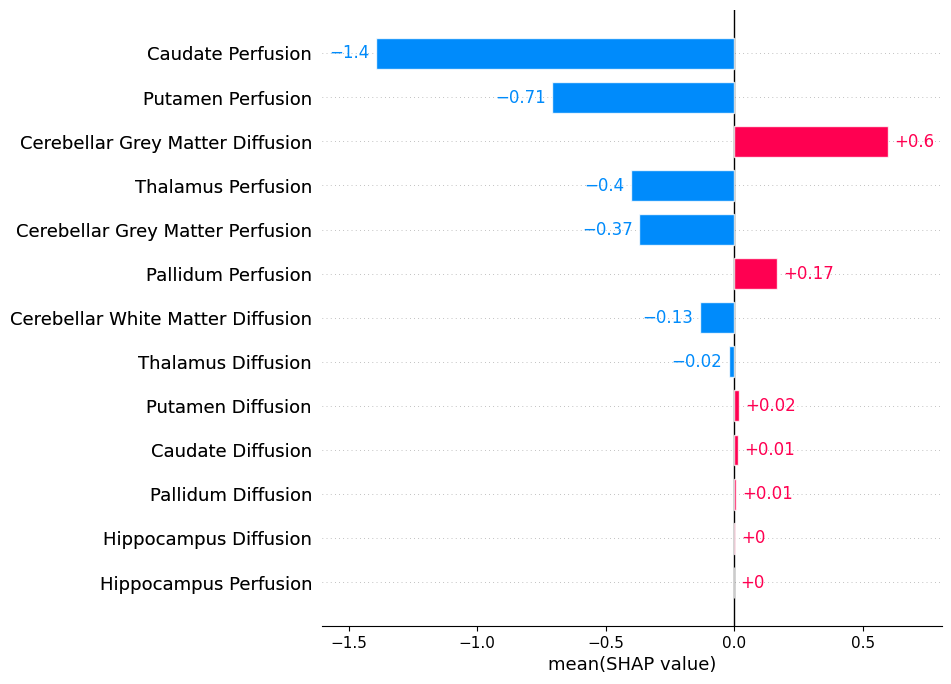



(16, 20, 13) (13,)
Beeswarm Plot for feature 2
Beeswarm Plot for Pallidum Perfusion


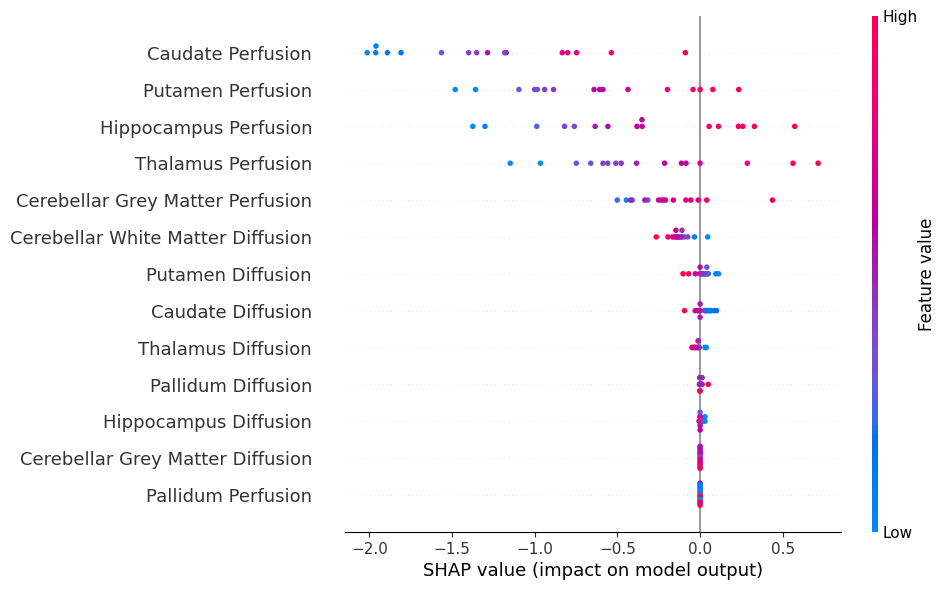

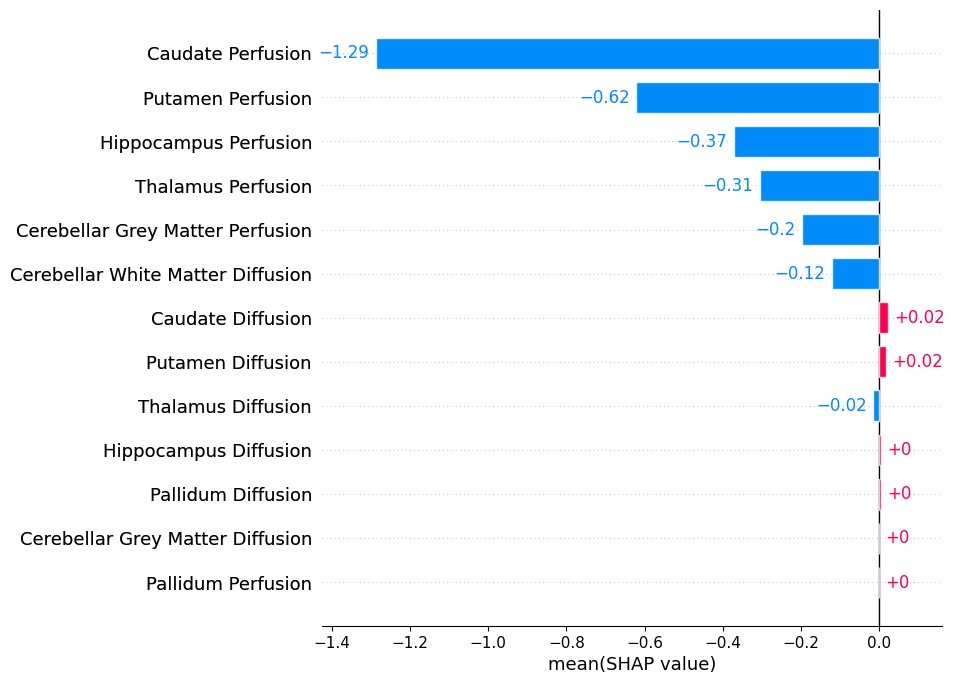



(16, 20, 13) (13,)
Beeswarm Plot for feature 3
Beeswarm Plot for Putamen Perfusion


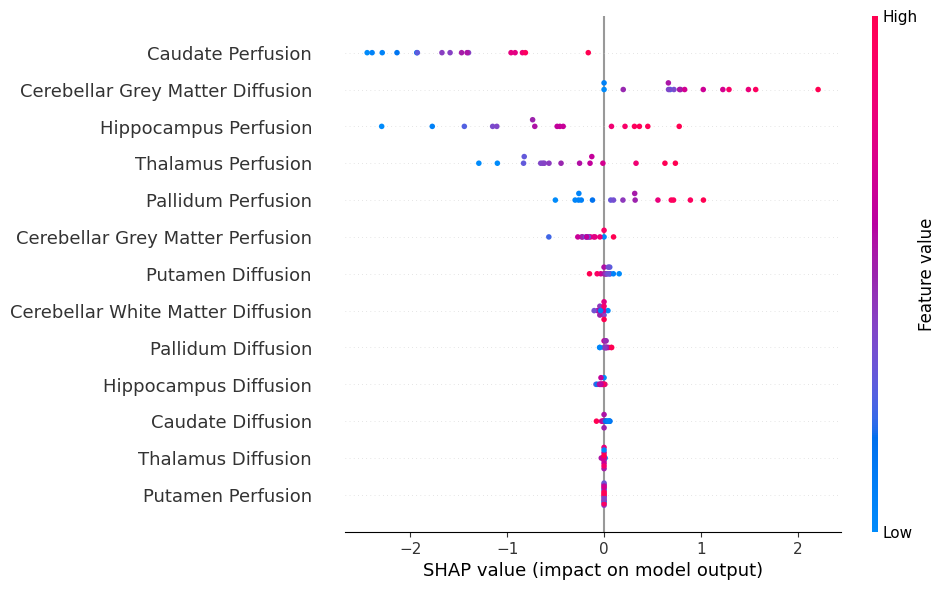

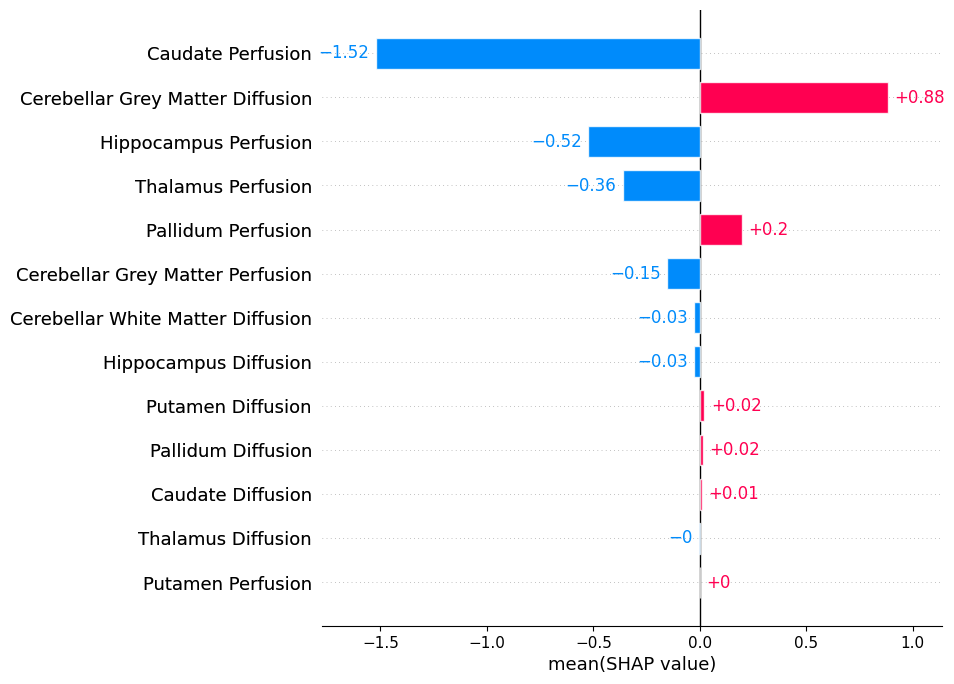



(16, 20, 13) (13,)
Beeswarm Plot for feature 4
Beeswarm Plot for Thalamus Perfusion


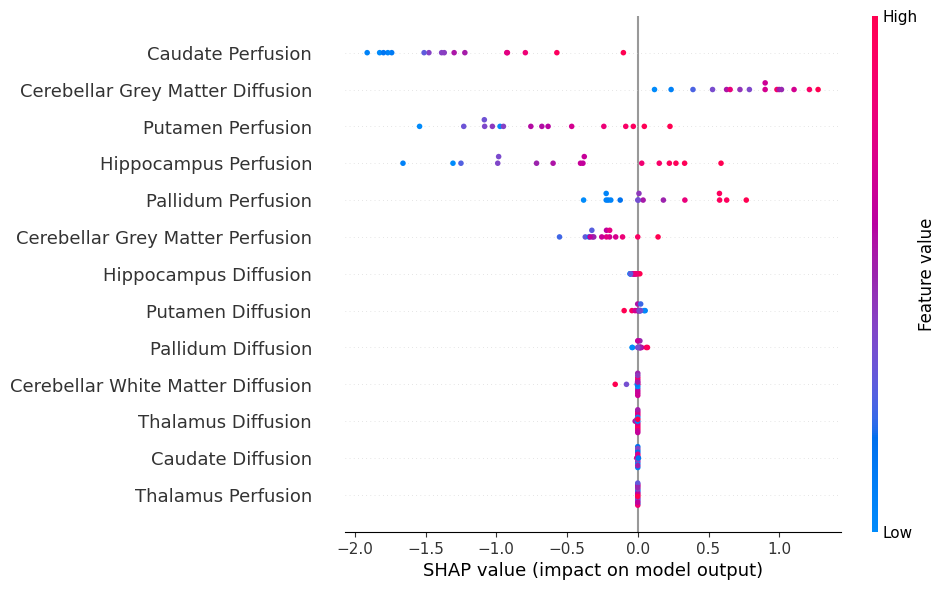

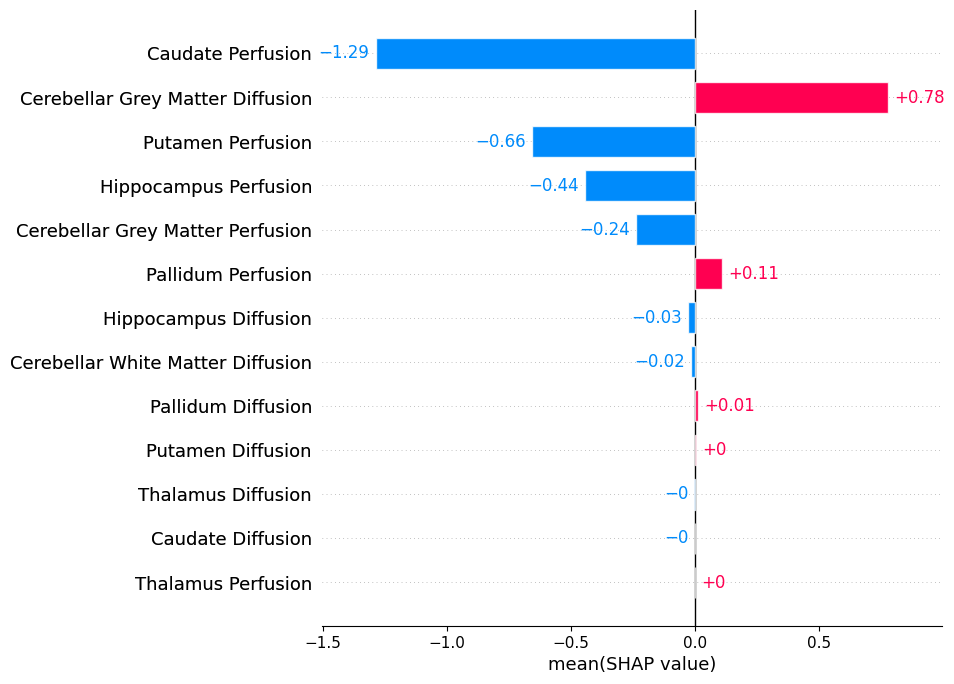



(16, 20, 13) (13,)
Beeswarm Plot for feature 5
Beeswarm Plot for Cerebellar Grey Matter Perfusion


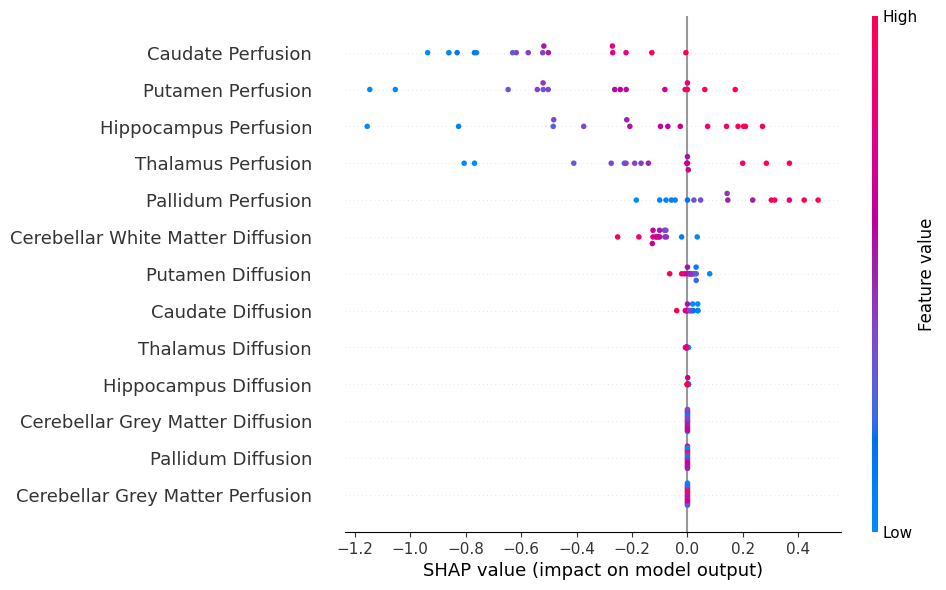

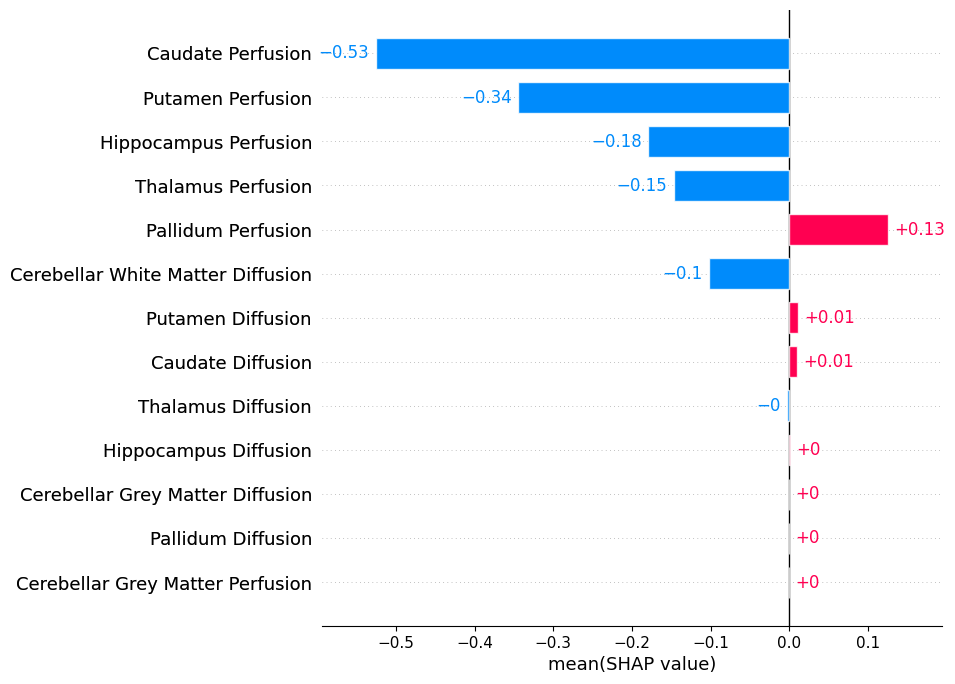



(16, 20, 13) (13,)
Beeswarm Plot for feature 6
Beeswarm Plot for Caudate Diffusion


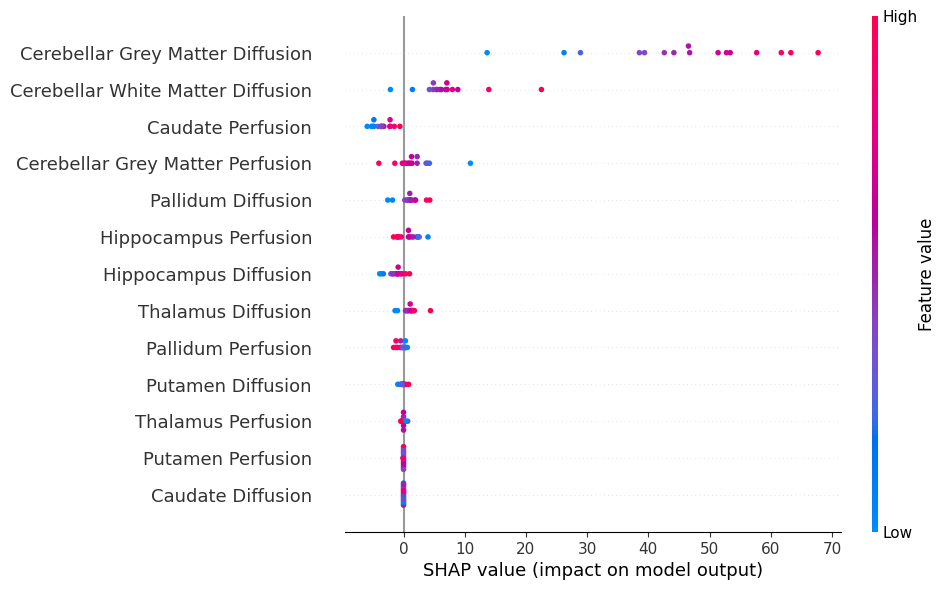

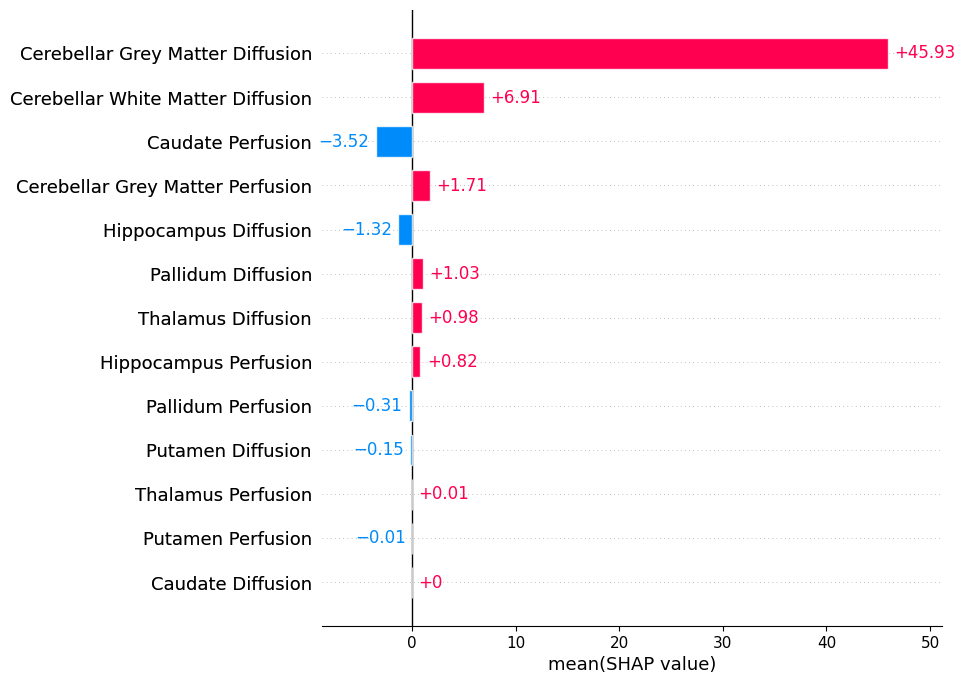



(16, 20, 13) (13,)
Beeswarm Plot for feature 7
Beeswarm Plot for Hippocampus Diffusion


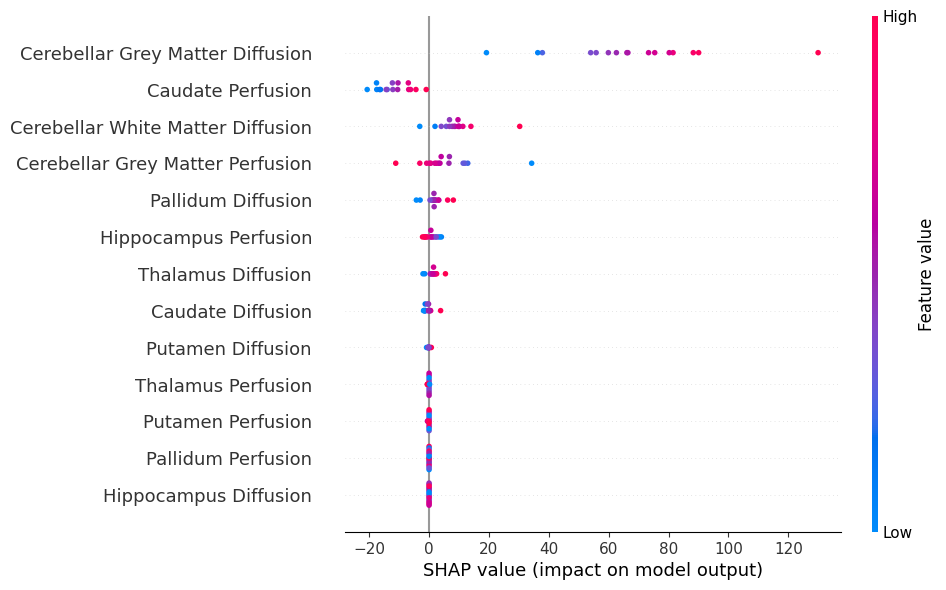

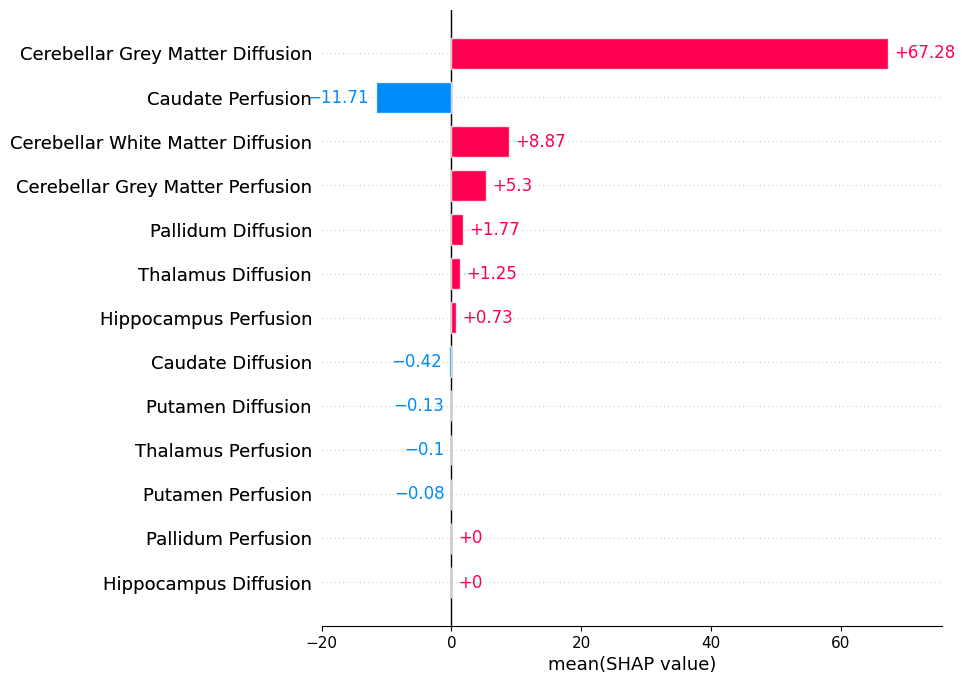



(16, 20, 13) (13,)
Beeswarm Plot for feature 8
Beeswarm Plot for Pallidum Diffusion


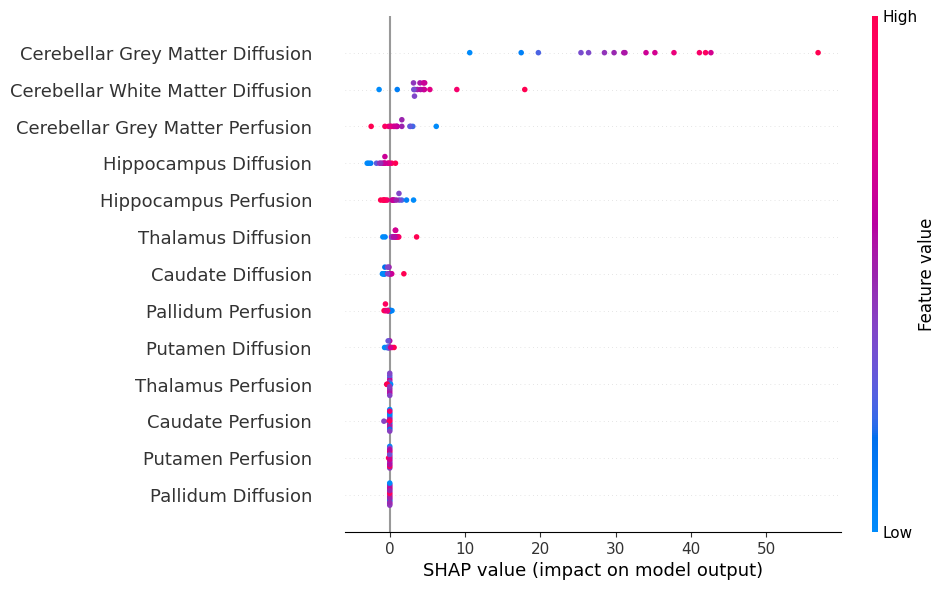

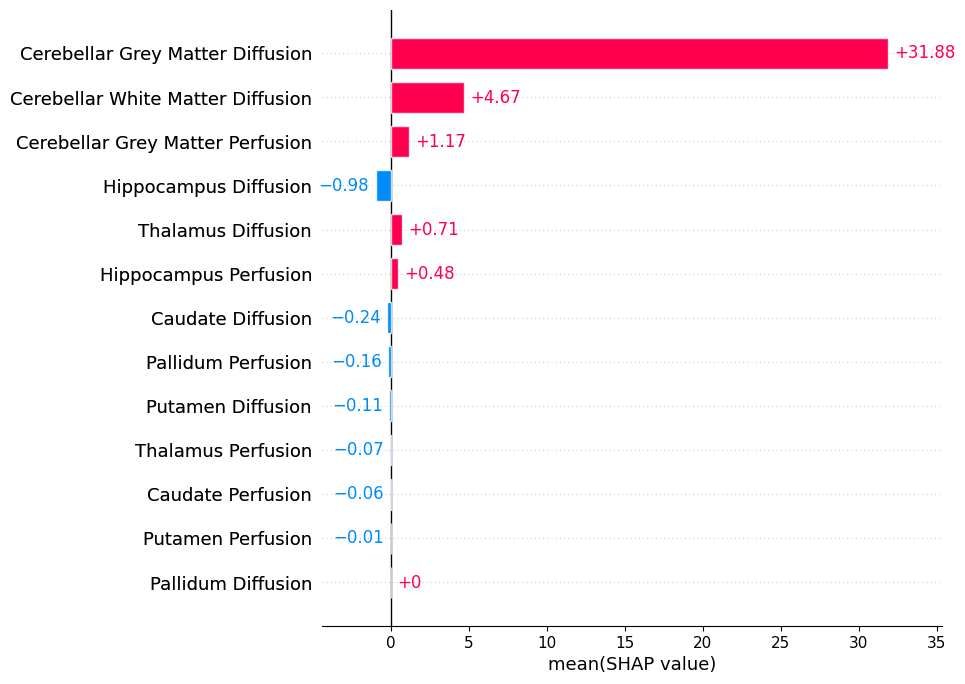



(16, 20, 13) (13,)
Beeswarm Plot for feature 9
Beeswarm Plot for Putamen Diffusion


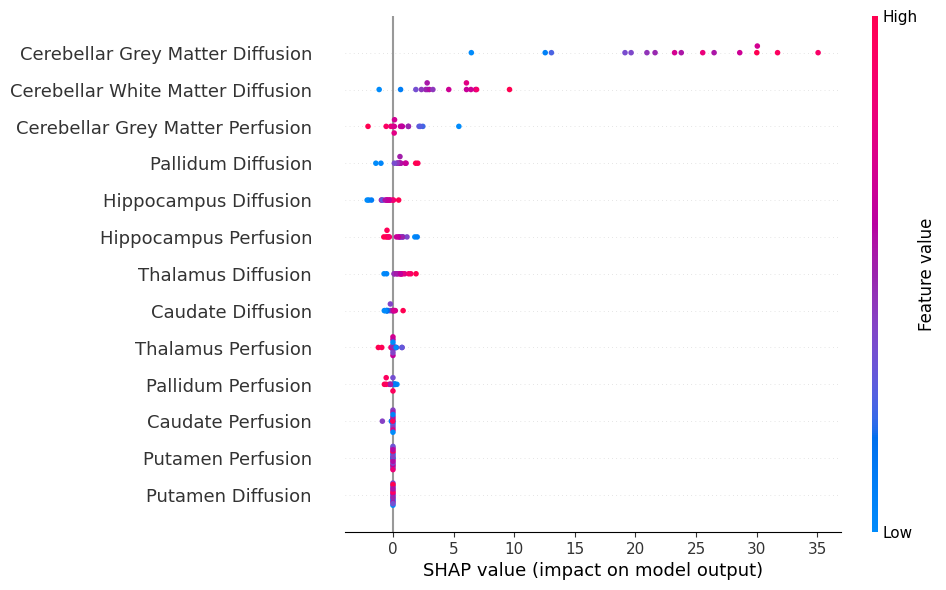

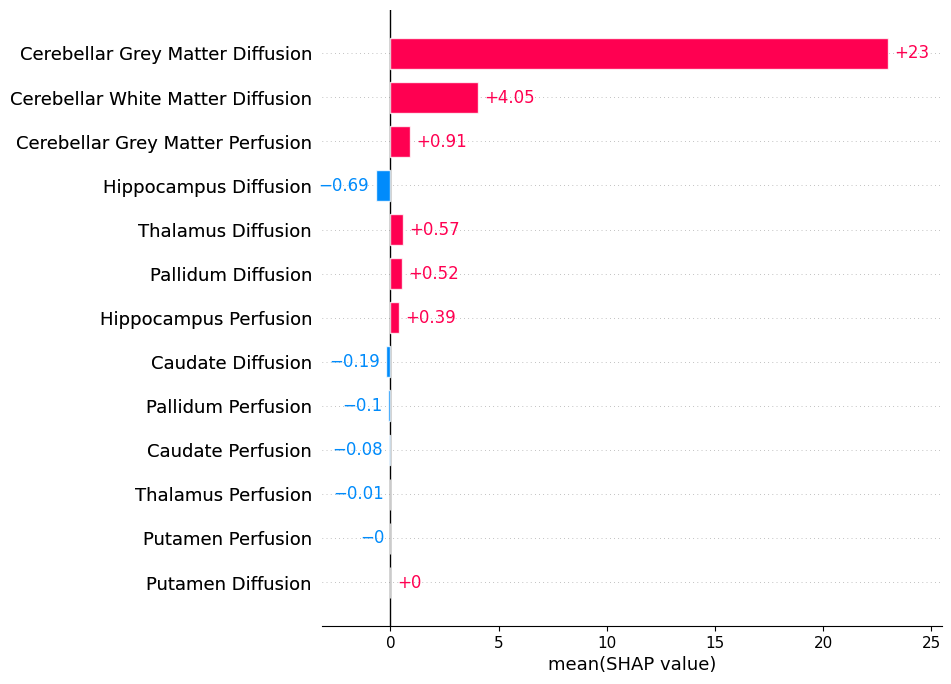



(16, 20, 13) (13,)
Beeswarm Plot for feature 10
Beeswarm Plot for Thalamus Diffusion


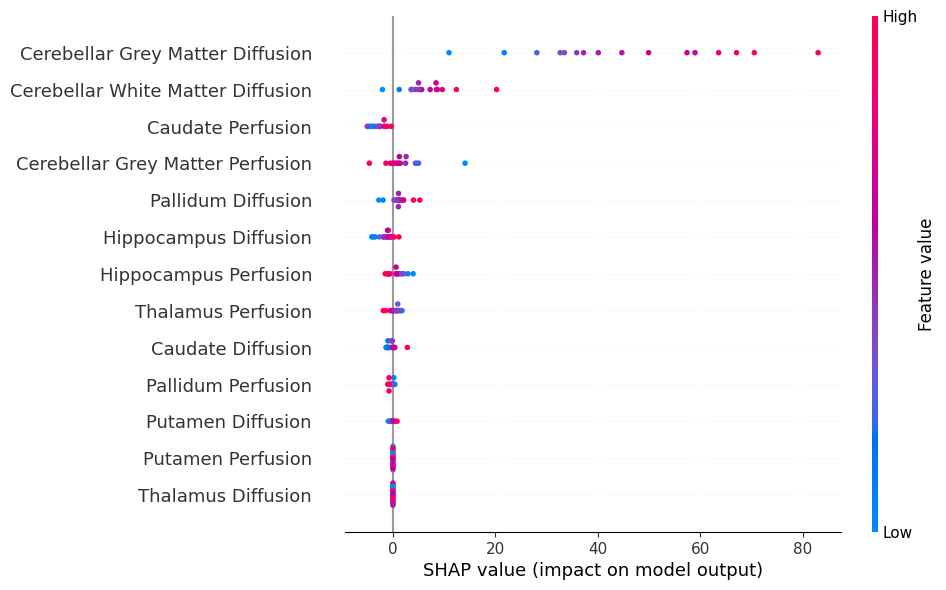

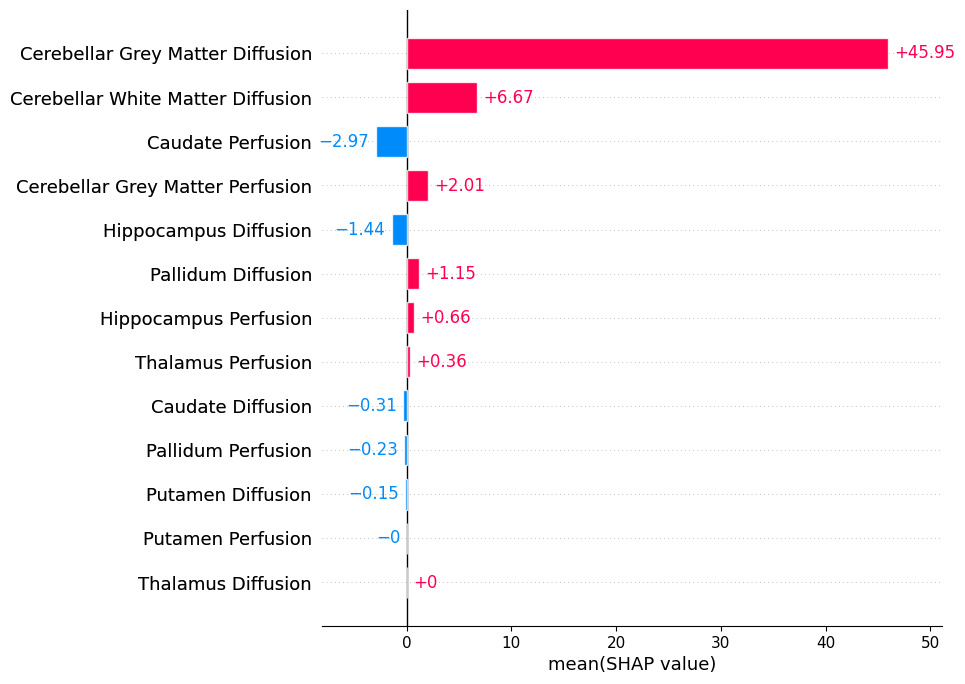



(16, 20, 13) (13,)
Beeswarm Plot for feature 11
Beeswarm Plot for Cerebellar Grey Matter Diffusion


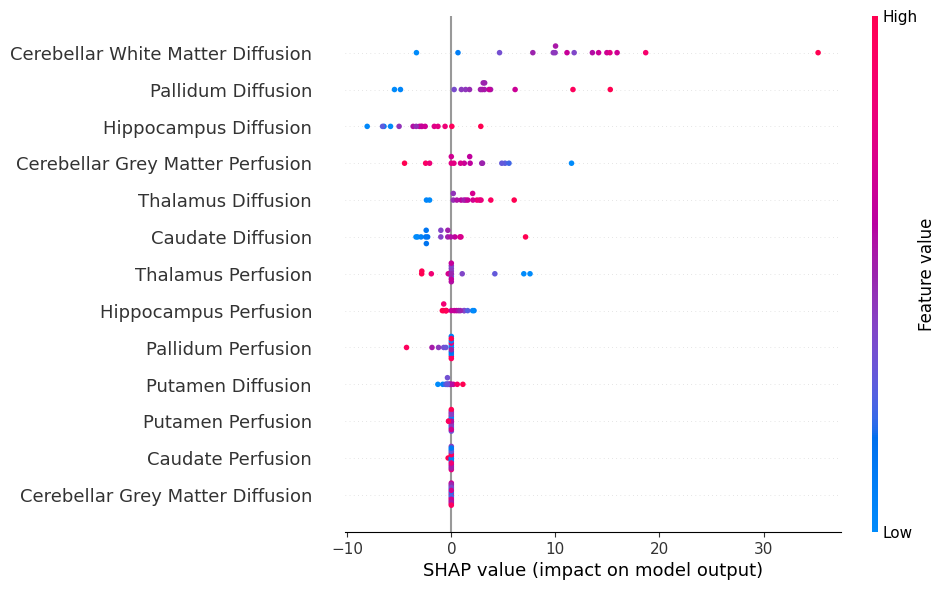

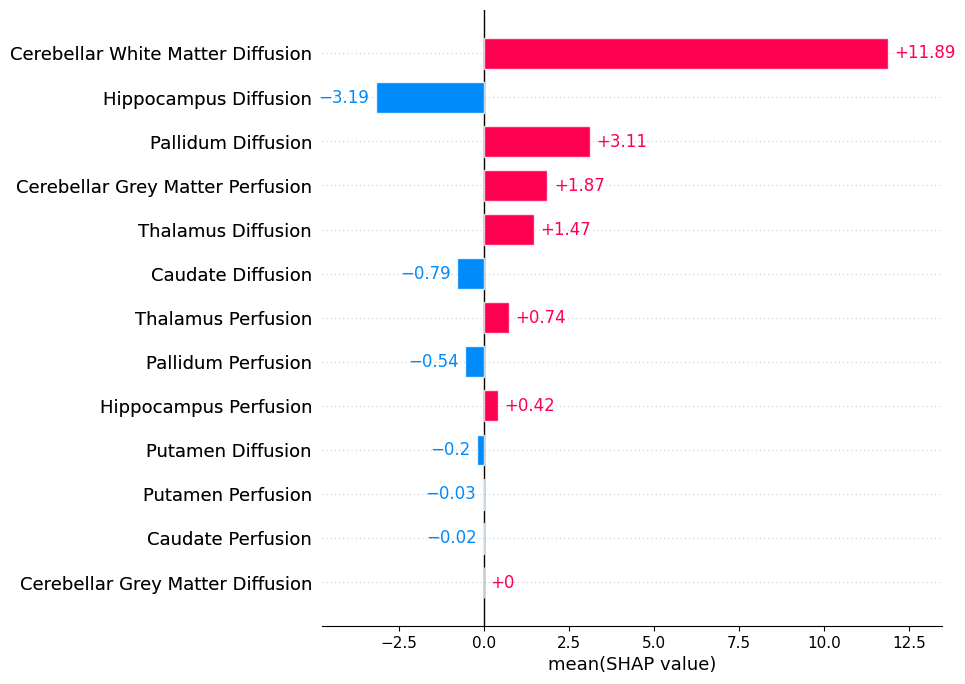



(16, 20, 13) (13,)
Beeswarm Plot for feature 12
Beeswarm Plot for Cerebellar White Matter Diffusion


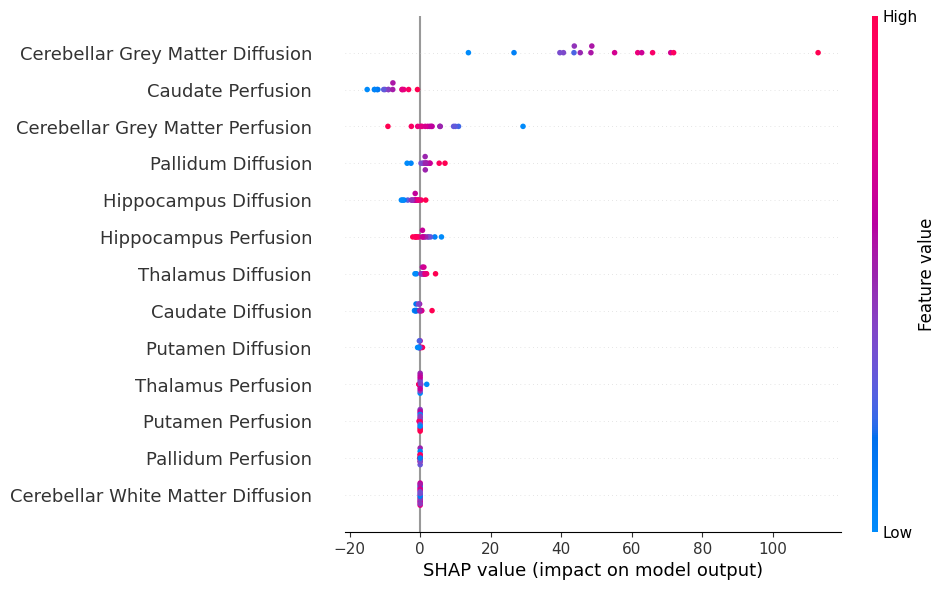

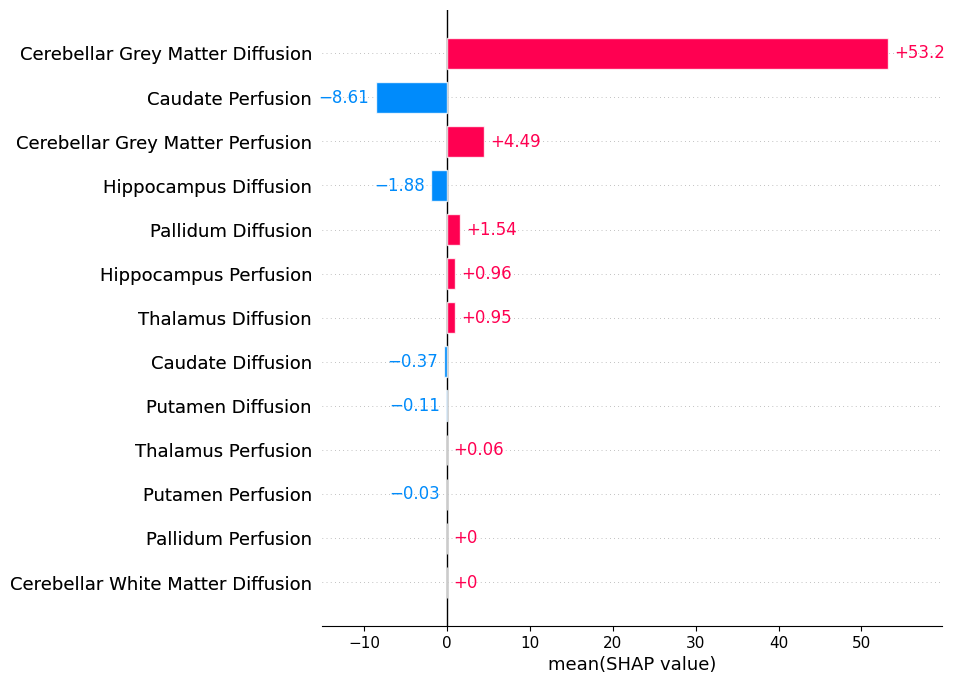

In [ ]:
import matplotlib.pyplot as plt
import os

# Analized feature
sv = []  #compendio shap
for feature in range(13):
  # feature = 1

  # Models
  # model = best5models[0]
  # model_0 = get_zero_feature_model(model, feature)  # excludes the influence of feature i on itself

  # # Explainer
  # explainer = shap.DeepExplainer(model_0, control)

  # Shap values
  expected_values, shap_values = ensemble_shap(best5models, feature, control, patient, 'median')
  print(shap_values.shape, expected_values.shape)
  shap_values = np.transpose(shap_values, (2, 0, 1))
  shap_values_original = [sv * 100 if feature < 6 else sv * 3000 for feature, sv in enumerate(shap_values)]
  expected_values_original = np.concatenate((expected_values[:6] * 100, expected_values[6:] * 3000))
  sv.append(shap_values_original[feature][:, 0:13])

  # Beeswarm Plot
  explanation = shap.Explanation(shap_values_original[feature][:, 0:13], expected_values_original[feature], patient_numpy[:, 0:13], feature_names=column_names)
  print(f'Beeswarm Plot for feature {feature}')
  print(f'Beeswarm Plot for {column_names[feature]}')
  shap.plots.beeswarm(explanation, max_display=13, show='False')
  shap.plots.bar(explanation.mean(0), max_display=13, show='False')
  print()

  plt.show()

  # Define the directory where you want to save the figures
  save_dir = "/content/drive/MyDrive/AT/figures/SHAP"  # Change this path to your desired directory

  # Ensure the directory exists, create it if not
  if not os.path.exists(save_dir):
      os.makedirs(save_dir)

  # Save the figures with a unique name based on the feature
  #beeswarm_filename = os.path.join(save_dir, f"beeswarm_{feature}.png")
  #bar_filename = os.path.join(save_dir, f"bar_{feature}.png")

  # Save the figures
  #plt.savefig(beeswarm_filename)
  #plt.savefig(bar_filename)

  # Close the current figure to avoid saving it multiple times
  plt.close()

  print()

In [ ]:
# Plot 1: Individual Force Plot

# Analized patient id
id = 0
feature=12

shap.initjs()

print(f'Force Plot for Feature {feature} and ID {id}')
shap.force_plot(expected_values_original[feature],
                shap_values_original[feature][id][0:13],
                feature_names=column_names)

Force Plot for Feature 12 and ID 0


In [ ]:
# Plot 2: All Force Plot

shap.initjs()


print(f'Force Plot for Feature {feature}')
shap.force_plot(expected_values_original[feature],
                shap_values_original[feature],
                feature_names=column_names,
                features=patient_numpy)

Force Plot for Feature 12


In [ ]:
# MEAN SHAPs
pd.concat([pd.DataFrame(np.mean([x * 100 for x in sv_std[:6]], axis=1), columns=column_names, index=column_names[:6]),
            pd.DataFrame(np.mean([x * 3000 for x in sv_std[6:]], axis=1), columns=column_names, index=column_names[6:])], axis=0)


,Caudate Perfusion,Hippocampus Perfusion,Pallidum Perfusion,Putamen Perfusion,Thalamus Perfusion,Cerebellar Grey Matter Perfusion,Caudate Diffusion,Hippocampus Diffusion,Pallidum Diffusion,Putamen Diffusion,Thalamus Diffusion,Cerebellar Grey Matter Diffusion,Cerebellar White Matter Diffusion
Caudate Perfusion,0.000000,-0.512188,0.166070,-0.712719,-0.425754,-0.258351,0.012895,0.000820,0.013014,0.026375,-0.009574,1.021557,-0.113000
Hippocampus Perfusion,-1.395730,0.000000,0.167566,-0.709676,-0.402014,-0.369639,0.014142,0.001278,0.006904,0.017308,-0.021396,0.597685,-0.134252
Pallidum Perfusion,-1.287600,-0.372772,0.000000,-0.621891,-0.305869,-0.198710,0.021733,0.004802,0.004798,0.017471,-0.016510,0.000000,-0.121889
Putamen Perfusion,-1.522763,-0.523933,0.200099,0.000000,-0.362814,-0.152514,0.010437,-0.025989,0.016980,0.021701,-0.003496,0.883275,-0.026726
Thalamus Perfusion,-1.288294,-0.442386,0.110224,-0.656514,0.000000,-0.236065,-0.000446,-0.026924,0.012449,0.003333,-0.001824,0.778474,-0.015337
Cerebellar Grey Matter Perfusion,-0.526153,-0.179041,0.125446,-0.344473,-0.147180,0.000000,0.009337,0.001231,0.000000,0.011499,-0.002984,0.000000,-0.102329
Caudate Diffusion,-3.516633,0.823175,-0.310209,-0.008762,0.012833,1.707974,0.000000,-1.315460,1.025220,-0.148105,0.982163,45.928801,6.913863
Hippocampus Diffusion,-11.706873,0.733192,0.001189,-0.078568,-0.102742,5.301998,-0.424310,0.000000,1.773144,-0.134313,1.245483,67.281368,8.874077
Pallidum Diffusion,-0.056963,0.478594,-0.162431,-0.012535,-0.068554,1.174538,-0.236014,-0.982444,0.000000,-0.110204,0.707293,31.879525,4.670046
Putamen Diffusion,-0.076404,0.386270,-0.095719,-0.000954,-0.007296,0.908069,-0.189177,-0.691409,0.517411,0.000000,0.574671,22.996906,4.054831


# Anomaly scores
Correlate with clinical variables

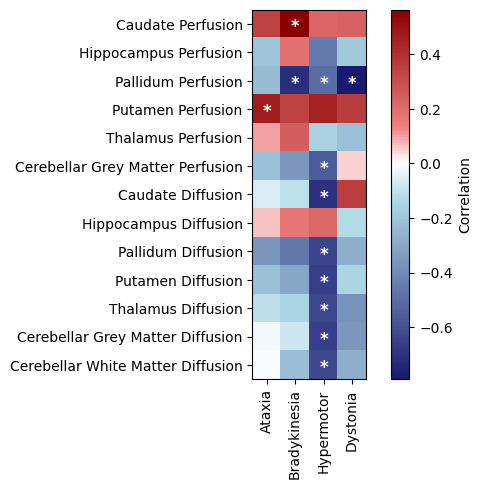

In [ ]:
# Plot Heatmap
fig, ax = plt.subplots()
cmap = colors.LinearSegmentedColormap.from_list(
    'Custom',
    [(0, 'midnightblue'), ((abs(np.min(arr)))/(np.max(arr)-np.min(arr)) - 0.1, 'lightblue'), ((abs(np.min(arr)))/(np.max(arr)-np.min(arr)), 'white'), ((abs(np.min(arr)))/(np.max(arr)-np.min(arr)) + 0.1, 'lightcoral'), (1, 'darkred')],
    N=256
)

im = ax.imshow(arr, cmap=cmap)

xlabs = clinic.columns[5:]
ylabs = column_names

# Add labels
ax.set_xticks(np.arange(len(xlabs)))
ax.set_yticks(np.arange(len(ylabs)))
ax.set_xticklabels(xlabs, rotation=90)
ax.set_yticklabels(ylabs)

for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        if p_perm_MC[i,j] < 0.05:
            ax.text(j, i + 0.1, "*", ha="center", va="center", color="white", fontsize=12, fontweight='bold')
        elif p_perm[i,j] < 0.05:
            ax.text(j, i + 0.1, "*", ha="center", va="center", color="white", fontsize=12, fontweight='bold')

cbar = plt.colorbar(im)
cbar.set_label('Correlation')

plt.show()